<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/VU_logo.png/800px-VU_logo.png?20161029201021" width="350">

### Programming large-scale parallel systems

# Partial Differential Equations (PDEs)

## Contents

In this notebook, we will learn

- Key concepts for the solution of PDEs on large-scale computers
- What is a preconditioner
- What is a multi-grid solver
- Parallelization of conjugate gradient method
- Distributed sparse matrix-vector product

## Mini project

- Simulating the temperature distribution in a closed room

### Problem statement

- Given the temperature at the boundary of a room (walls, window, heater)
- Predict the temperature at any point of the room
- Compute it in parallel

<div>
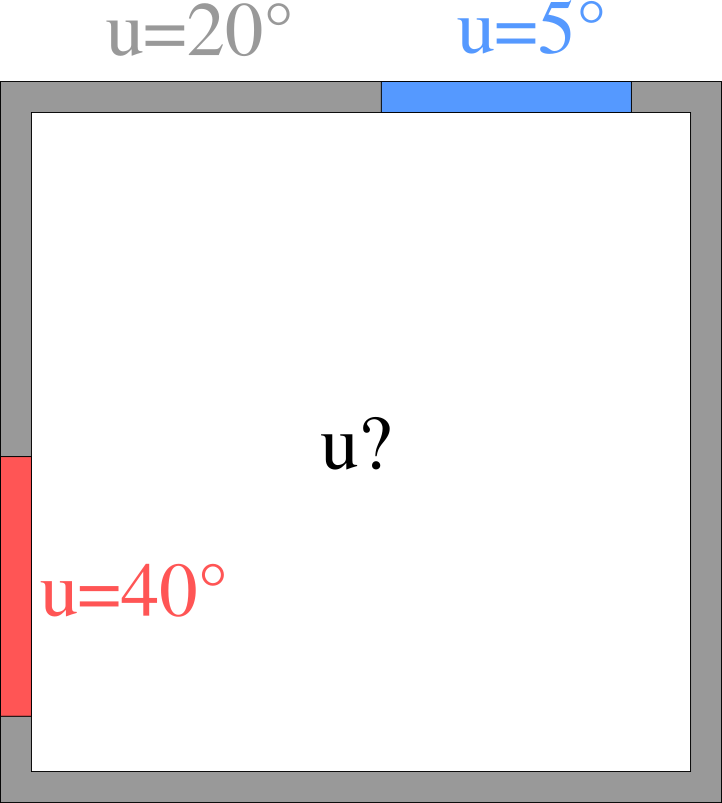
</div>


### Laplace equation

$\dfrac{\partial^2 u(x,y)}{\partial x^2} + \dfrac{\partial^2 u(x,y)}{\partial y^2} = 0$


 Pierre-Simon, marquis de Laplace (1749-1827)
 
 *Picture from wikipedia*

<div>
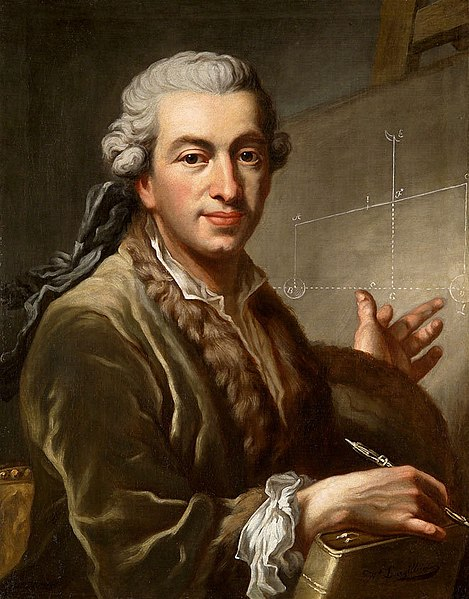
</div>

### Boundary value problem (BVP)

$\dfrac{\partial^2 u}{\partial x^2} + \dfrac{\partial^2 u}{\partial y^2} = 0 \text{ in the room}$

$u = 5 \text{ on the window}$

$u = 40 \text{ on the heater}$

$u = 20 \text{ on the walls}$


<div>
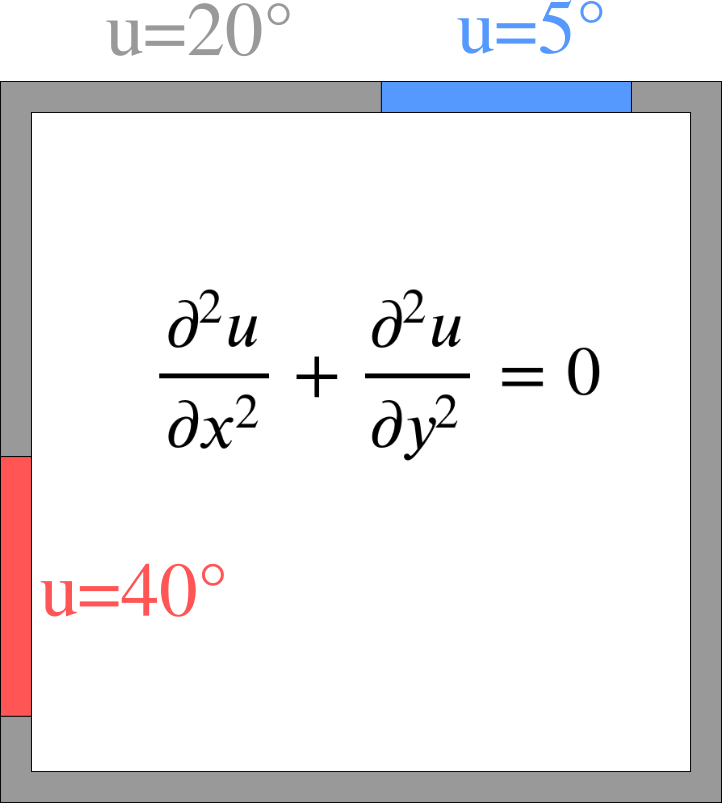
</div>

### Numerical methods for PDEs

- Finite difference method (FDM)
- Finite element method (FEM)
- Finite volume method (FVM)
- Boundary element method (BEM)
- Meshfree methods

Main idea: Transform a PDE into a system of algebraic equations.



<div>
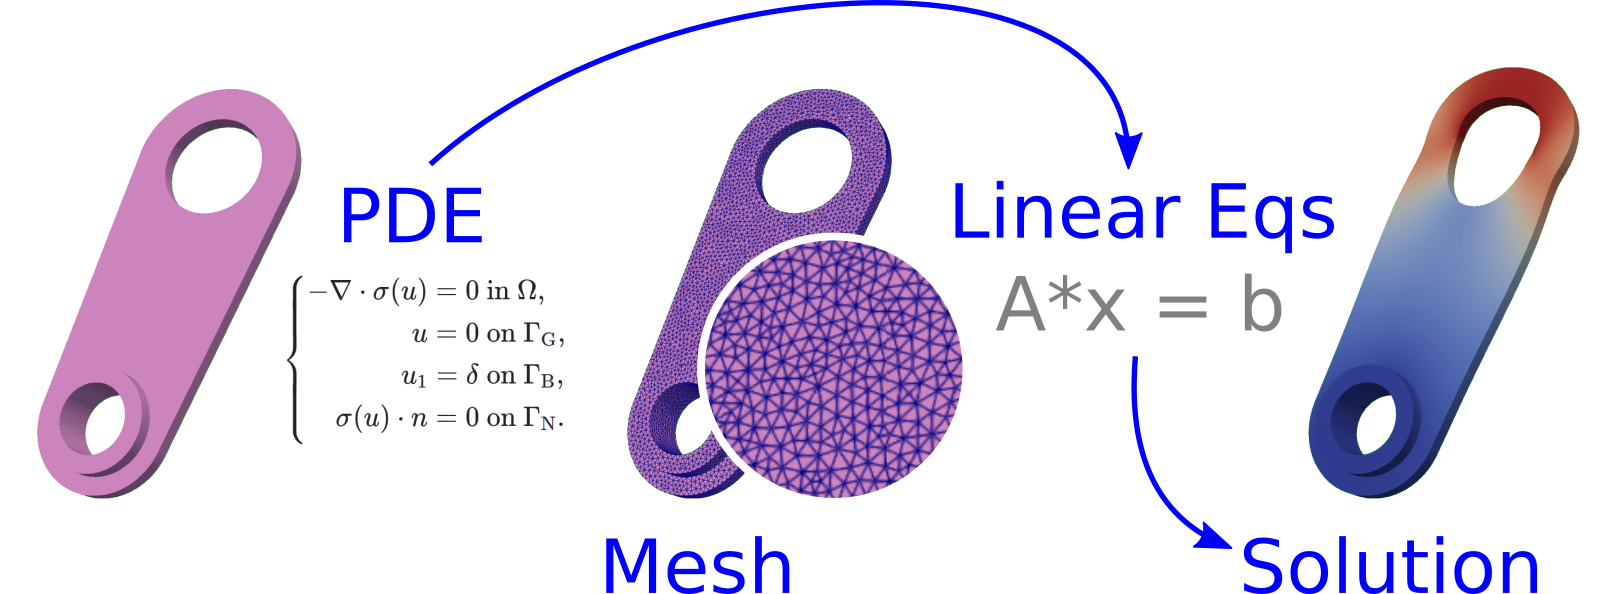
</div>

### Finite Difference method

 - Pro: Easy to implement and computationally efficient
 - Con: Difficult to handle complex geometries


<div>
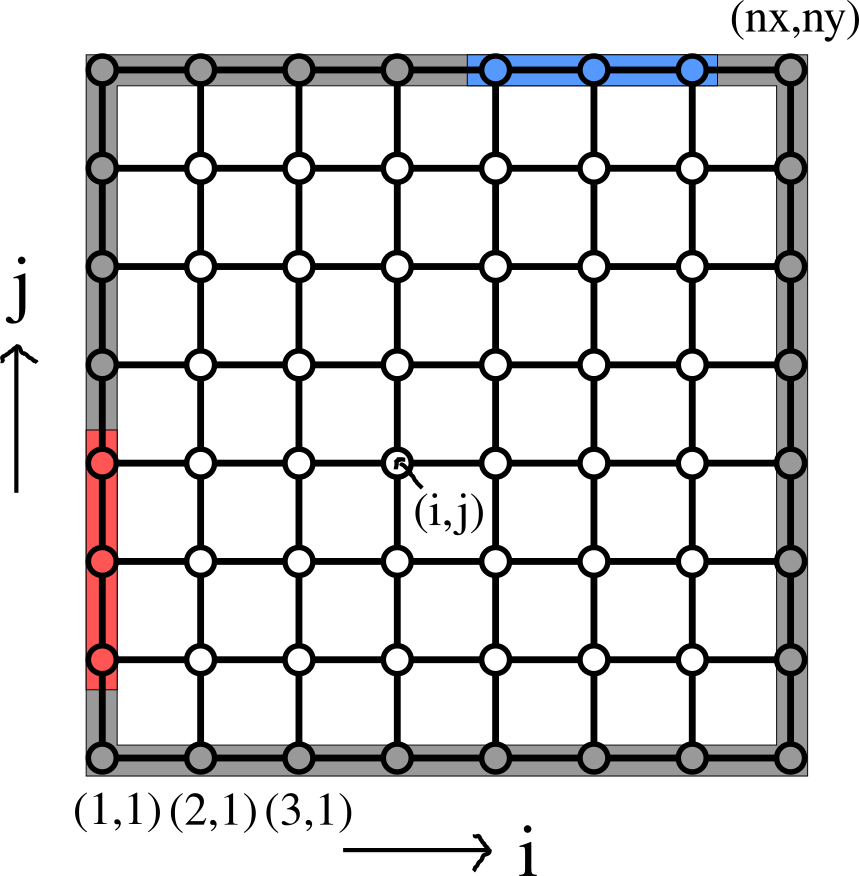
</div>


- Goal: Compute the temperature at each grid point
- The (unknown) values can be stored in a computer using an array
- `u[i,j]` is the temperature at point $(i,j)$

In [ ]:
] add Plots IterativeSolvers Preconditioners Printf SparseArrays LinearAlgebra

In [ ]:
N = 8
u = zeros(N,N)

In [ ]:
function fill_boundary!(u)
    u_window = 5.0
    u_heater = 40.0
    u_wall = 20.0
    window_span = (0.6,0.9)
    heater_span = (0.2,0.4)
    nx,ny = size(u)
    hx,hy = 1 ./ (nx-1,ny-1)
    for j in 1:ny
        y = hy*(j-1)
        for i in 1:nx
            x = hx*(i-1)
            if j==ny && (window_span[1]<=x && x<=window_span[2])
                u[i,j] = u_window
            elseif i==1 && (heater_span[1]<=y && y<=heater_span[2])
                u[i,j] = u_heater
            elseif (j==1||j==ny) || (i==1||i==ny)
                u[i,j] = u_wall
            end
        end
    end
    u
end

In [ ]:
fill_boundary!(u)

### Data Visualization

In [ ]:
using Plots

In [ ]:
function visualize(u;title="Temperature distribution")
    xlabel="x-coordinate"
    ylabel="y-coordinate"
    aspectratio = :equal
    plt = plot(;size= 1.5 .*(350,300),title,xlabel,ylabel,aspectratio,fontsize=100)
    nx,ny = size(u)
    hx,hy = (1,1) ./ (nx-1,ny-1)
    x = hx .* ((1:nx) .- 1)
    y = hy .* ((1:ny) .- 1)
    heatmap!(x,y,transpose(u),color=:thermal)
    plt
end

In [ ]:
visualize(u)

### How to find the temperature at the interior points?

- We have an unknown for each interior point
- We need an equation for each unknown
- How to define these equations?


### Finite Difference stencil



$\dfrac{\partial^2 u}{\partial x^2} + \dfrac{\partial^2 u}{\partial y^2} = 0 $

$\downarrow$

$u_{i-1,j} + u_{i+1,j} + u_{i,j-1} + u_{i,j+1} - 4u_{i,j} = 0$




<div>
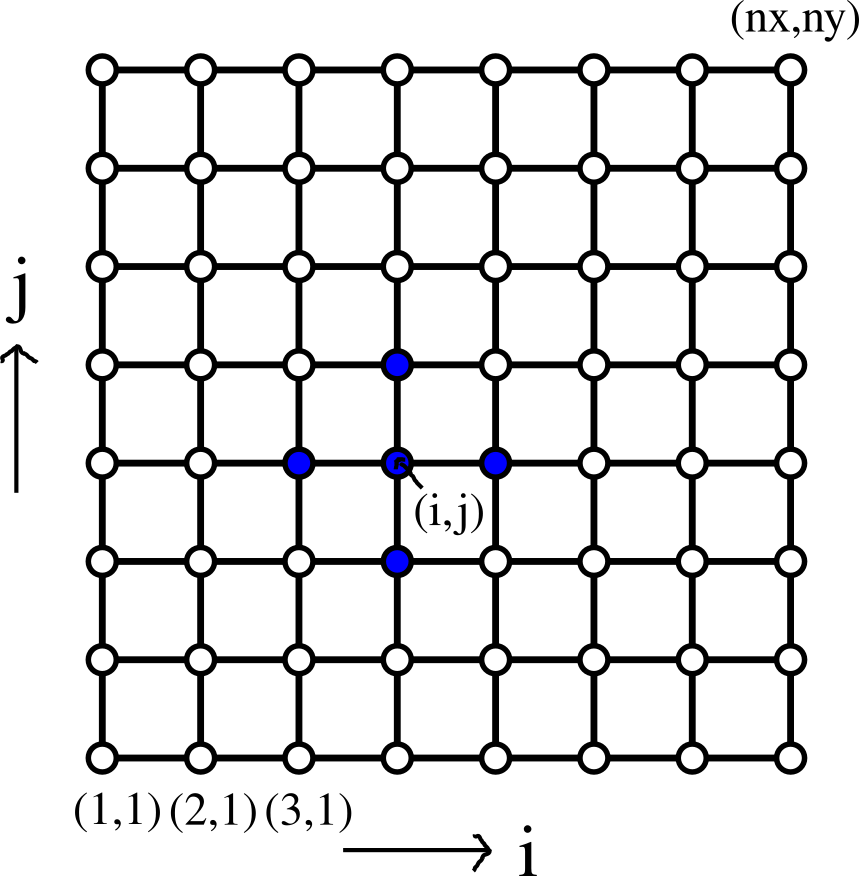
</div>


### System of linear equations
 
 - At each interior point we have an equation
 - All these equations can be arranged in array form
 
$Ax=b$

In [ ]:
using SparseArrays
function generate_system_sparse(u)
    nx,ny = size(u)
    stencil = [(-1,0),(1,0),(0,-1),(0,1)]
    nnz_bound = 5*nx*ny
    nrows = (nx-2)*(ny-2)
    ncols = nrows
    b = zeros(nrows)
    I = zeros(Int,nnz_bound)
    J = zeros(Int,nnz_bound)
    V = zeros(nnz_bound)
    inz = 0
    for j in 2:(ny-1)
        for i in 2:(nx-1)
            row = i-1 + (ny-2)*(j-2)
            inz += 1
            I[inz] = row
            J[inz] = row
            V[inz] = 4.0
            for (di,dj) in stencil
                on_boundary = i+di in (1,nx) || j+dj in (1,ny)
                if on_boundary
                    b[row] += u[i+di,j+dj]
                    continue
                end
                col = i+di-1 + (ny-2)*(j+dj-2)
                inz += 1
                I[inz] = row
                J[inz] = col
                V[inz] = -1.0
            end
        end
    end
    A = sparse(view(I,1:inz),view(J,1:inz),view(V,1:inz),nrows,ncols)
    A,b
end

In [ ]:
N = 5
u = zeros(N,N)
A, b = generate_system_sparse(u)
A

$u_{i-1,j} + u_{i+1,j} + u_{i,j-1} + u_{i,j+1} - 4u_{i,j} = 0$

<div>
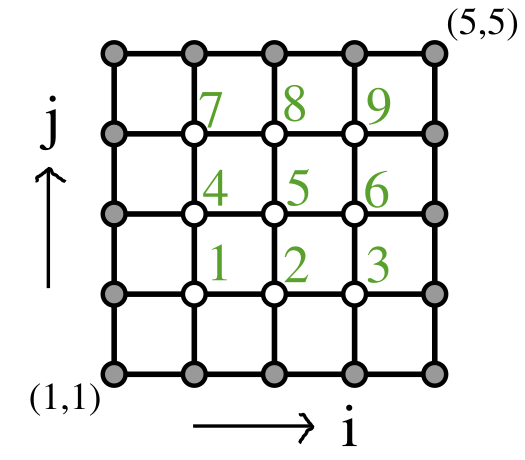
</div>

### Solution methods

Two possible solution methods have already been discussed in the course:

- Jacobi
- Gaussian elimination

### Algorithmically scalable solver

- If the total cost scales at most linearly with respect to the total problem size

<div class="alert alert-block alert-success">
<b>Question:</b>  Are Gaussian elimination and Jacobi algorithmically scalable?
</div>

- Answer: NO.

- Problem size is R = O(N^2)

- Gaussian Elimination: O(R^3) (more than linear)

- Jacobi: O(N^2) = O(R) per iteration. Linear per iteration, but how many iterations?



### Complexity of Jacobi method


In [ ]:
using LinearAlgebra
function jacobi!(u,f=zeros(size(u));reltol=0.0,maxiters=0)
    u_new = copy(u)
    e = similar(u)
    ni,nj = size(u)
    for iter in 1:maxiters
        for j in 2:(nj-1)
            for i in 2:(ni-1)
                u_new[i,j] =
                  0.25*(u[i-1,j] + u[i+1,j] + u[i,j-1] + u[i,j+1] + f[i,j])
            end
        end
        e .= u_new .- u
        relerror = norm(e)/norm(u_new)
        if relerror < reltol
            return u_new, iter
        end
        u, u_new = u_new, u
    end
    u, maxiters
end

In [ ]:
N = 40
u = zeros(N,N)
fill_boundary!(u)
u, iter = jacobi!(u,reltol=1.0e-5,maxiters=1000000)
println("Jacobi converged in $iter iterations")
visualize(u)

### Convergence analysis

In [ ]:
plt = plot(xlabel="N^2",ylabel="Iterations");

In [ ]:
Ns = [20,40,80,160]
reltol = 1.0e-6
iters = zeros(size(Ns))
for (i,N) in enumerate(Ns)
    u = zeros(N,N)
    fill_boundary!(u)
    u, iter = jacobi!(u;reltol=reltol,maxiters=1000000)
    iters[i] = iter
end
plot!(plt,Ns.^2,iters,xaxis=:log10,yaxis=:log10,label="reltol=$reltol (Jacobi)",marker=:auto)
plt

- The number of iterations to achieve a relative error of $10^{-s}$ increases as $O(s N^2)$
- Remember: The cost per iteration is $O(N^2)$
- Total cost is $O(N^4) = O((N^2)^2) $

### Complexity of some solvers

Work to solve a Laplace equation on a regular mesh of $S$ points ($S=N^d$)

| Solver | 1D | 2D | 3D |
|--|--|--|--|
| Dense Cholesky | O(S^3) | O(S^3) | O(S^3) |
| Sparse Cholesky | O(S) | O(S^1.5) | O(S^2) |
| Conjugate gradient + Multi grid | O(S) | O(S) | O(S) |


### Conjugate gradient method

- Idea: Transform the problem into an optimization problem

$A x = b$

equivalent to 

$ x = \text{arg }\min_{y} f(y)$ with $ f(y)= \frac{1}{2}( y^\mathrm{T}Ay - y^\mathrm{T} b )$

- We can use some sort of gradient descent to solve it

- The [Conjugate Gradient Method](https://en.wikipedia.org/wiki/Conjugate_gradient_method) is a gradient descent algorithm optimized for symmetic ($A^\mathrm{T}=A$) positive-definite ($y^\mathrm{T}Ay > 0$) matrices
- It is applicable to our problem
- It is a type of Krylov subspace method

### Top 10 algorithms of the 20th century

According to IEEE Computer Society

- Metropolis Algorithm for Monte Carlo
- Simplex Method for Linear Programming
- **Krylov Subspace Iteration Methods**
- The Decompositional Approach to Matrix Computations
- The Fortran Optimizing Compiler
- QR Algorithm for Computing Eigenvalues
- Quicksort Algorithm for Sorting
- Fast Fourier Transform
- Integer Relation Detection
- Fast Multipole Method



In [ ]:
using IterativeSolvers: cg!
N = 80
u = zeros(N,N)
fill_boundary!(u)
A,b = generate_system_sparse(u)
x = zeros(length(b))
_,ch = cg!(x, A, b, reltol=1e-5,log=true)
display(ch)
u[2:end-1,2:end-1] = x
visualize(u)

### Convergence analysis

In [ ]:
#plt = plot(xlabel="N^2",ylabel="Iterations");

In [ ]:
Ns = [20,40,80,160]
reltol = 1.0e-5
iters = zeros(size(Ns))
for (i,N) in enumerate(Ns)
    u = zeros(N,N)
    fill_boundary!(u)
    A,b = generate_system_sparse(u)
    x = zeros(length(b))
    _,ch = cg!(x, A, b, reltol=reltol,log=true)
    iters[i] = ch.iters
end
plot!(plt,Ns.^2,iters,xaxis=:log10,yaxis=:log10,label="reltol=$reltol (CG)",marker=:auto)
plt

### Number of iterations


- The number of iterations to achieve a relative error of $10^{-s}$ increases as $O(s \sqrt{\kappa(A)})$
- $\kappa(A)=\dfrac{\lambda_{max}(A)}{\lambda_{min}(A)}$ is the condition number of A (ratio between the largest and smallest eigenvalues)
- In our example,  $\kappa(A) = O(N^2)$
- Thus, the iterations number scales as $O(s N)$


### Goal

- Find an iterative method whose number of iterations is independent of problem size

### Preconditioner

A linear function $M$ such that

$M(b) \approx x$ with $Ax=b$ for any $b$

$\downarrow$

$ M(b) \approx A^{-1}b $

$\downarrow$

$ M \approx A^{-1}$

$\downarrow$

$ M A \approx I$ (Identity matrix)

$\downarrow$

$\kappa (MA) \approx 1$

$\downarrow$

Conjugate gradients will be fast when solving

$(MA)x = Mb \Longleftrightarrow  Ax=b$



### How to build a preconditioner  ?

- $M=A^{-1}$ (exact preconditioner, but as costly as solving the original problem)
- $M=I$ (no extra work, but slow convergence)
- We need a trade-off (maths + computer science problem)


### Jacobi Preconditioner

In [ ]:
struct JacobiPrec{T}
    u::Matrix{T}
    f::Matrix{T}
    niters::Int
end
function jacobi_prec(N;niters)
    u = zeros(N,N)
    f = zeros(N,N)
    JacobiPrec(u,f,niters)
end
function LinearAlgebra.ldiv!(x,M::JacobiPrec,b)
    M.u[2:end-1,2:end-1] .= 0 
    M.f[2:end-1,2:end-1] = b
    u,_ = jacobi!(M.u,M.f,reltol=0,maxiters=M.niters)
    x[:] = @view u[2:end-1,2:end-1]
    x
end

In [ ]:
N = 80
u = zeros(N,N)
fill_boundary!(u)
A,b = generate_system_sparse(u)
M = jacobi_prec(N,niters=10)
x = zeros(size(b))
ldiv!(x,M,b)
u[2:end-1,2:end-1] = x
visualize(u)

In [ ]:
Ns = [20,40,80,160]
reltol = 1.0e-5
iters = zeros(size(Ns))
for (i,N) in enumerate(Ns)
    u = zeros(N,N)
    fill_boundary!(u)
    A,b = generate_system_sparse(u)
    M = jacobi_prec(N,niters=100)
    x = zeros(length(b))
    _,ch = cg!(x, A, b, Pl=M, reltol=reltol,log=true)
    iters[i] = ch.iters
end
plot!(plt,Ns.^2,iters,xaxis=:log10,yaxis=:log10,label="reltol=$reltol (CG+Jacobi($(M.niters)))",marker=:auto)
plt

### How can we improve the Jacobi method?

In [ ]:
N = 10
u = zeros(N,N)
fill_boundary!(u)
A,b = generate_system_sparse(u)
M = jacobi_prec(N,niters=80)
x = zeros(size(b))
ldiv!(x,M,b)
u[2:end-1,2:end-1] = x
visualize(u)

### Multi-grid method


In [ ]:
function prolongate!(u_fine,u_coarse)
    ni_coarse, nj_coarse = size(u_coarse)
    ni_fine, nj_fine = size(u_fine)
    @assert 2*(ni_coarse-1) == (ni_fine-1)
    for j_fine in 1:nj_fine
        j_coarse = div(j_fine-1,2)+1
        j_rem = mod(j_fine-1,2)
        for i_fine in 1:ni_fine
            i_coarse = div(i_fine-1,2)+1
            i_rem = mod(i_fine-1,2)
            u_fine[i_fine,j_fine] = 0.25*(
                u_coarse[i_coarse,j_coarse] +
                u_coarse[i_coarse+i_rem,j_coarse] +
                u_coarse[i_coarse,j_coarse+j_rem] +
                u_coarse[i_coarse+i_rem,j_coarse+j_rem] )
        end
    end
end

In [ ]:
iters_in_level = [2,2,2,2,2,2,2,2]
u_coarse = zeros(2,2)
anim = @animate  for (level,iters) in enumerate(iters_in_level)
    N = 2^level
    u = zeros(1+N,1+N)
    prolongate!(u,u_coarse)
    fill_boundary!(u)
    global u_coarse
    u_coarse,_ = jacobi!(u,reltol=0,maxiters=iters)
    visualize(u,title="Level $level")
end
gif(anim,"a2.gif",fps=1)

### Multi-grid preconditioner

In [ ]:
using Preconditioners
Ns = [20,40,80,160]
reltol = 1.0e-5
iters = zeros(size(Ns))
for (i,N) in enumerate(Ns)
    u = zeros(N,N)
    fill_boundary!(u)
    A,b = generate_system_sparse(u)
    M = AMGPreconditioner{SmoothedAggregation}(A)
    x = zeros(length(b))
    _,ch = cg!(x, A, b, Pl=M, reltol=reltol,log=true)
    iters[i] = ch.iters
end
plot!(plt,Ns.^2,iters,xaxis=:log10,yaxis=:log10,label="reltol=$reltol (CG+MG)",marker=:auto)
plt

### Number of iterations


- The number of iterations to achieve a relative error of $10^{-s}$ increases as $O(s)$
- The cost of each iteration is proportional to the number of grid points


### High-performance conjugate gradient (HPCG) benchmark

- Alternative to HPL benchmark to rank the [top 500](https://www.top500.org/) computers


Fig. from DOI: [10.1177/1094342015593158](https://journals.sagepub.com/doi/10.1177/1094342015593158)
<div>
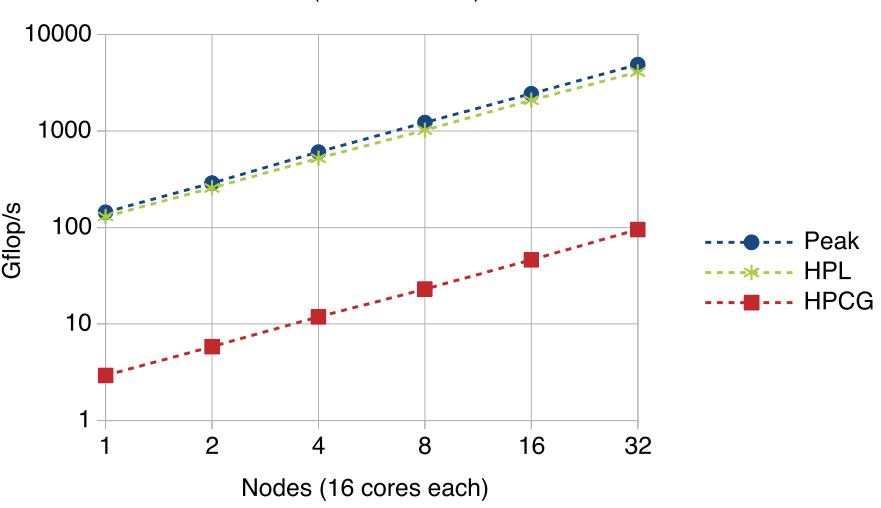
</div>

## Parallel implementation

### Conjugate gradient method

In [ ]:
function conjugate_gradient!(x,A,b;M,reltol,maxiters=size(A,1))
    c = similar(x)
    u = similar(x)
    r = similar(x)
    mul!(c,A,x)
    r .= b .- c
    norm_r0 = sqrt(dot(r,r))
    for iter in 1:maxiters
        ldiv!(c,M,r)
        ρ_prev = ρ
        ρ = dot(c,r)
        β = ρ / ρ_prev
        u .= c .+ β .* u
        mul!(c, A, u)
        α = ρ / dot(u,c)
        x .= x .+ α .* u
        r .= r .- α .* c
        if sqrt(dot(r,r)) < reltol*norm_r0
            break
        end
    end
    x
end

The phases that are not trivially parallel are

- Dot products
- Sparse matrix-vector products
- Preconditioners

### Dot product


$\text{dot}(a,b)=  \sum_i a_i b_i$


<div>
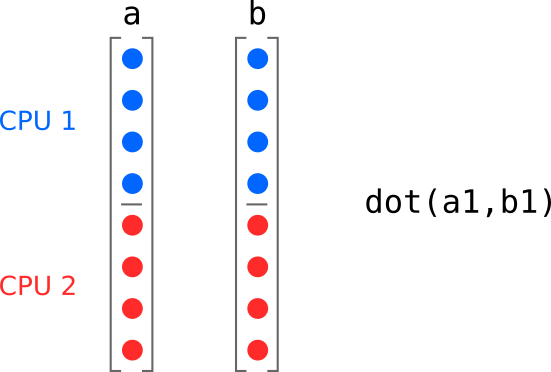
</div>

### MPI implementation

<div>
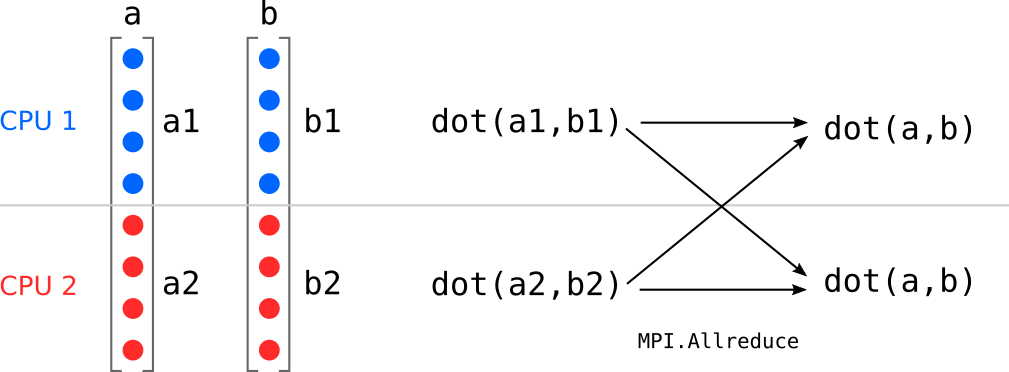
</div>


### Sparse matrix-vector product



<div>
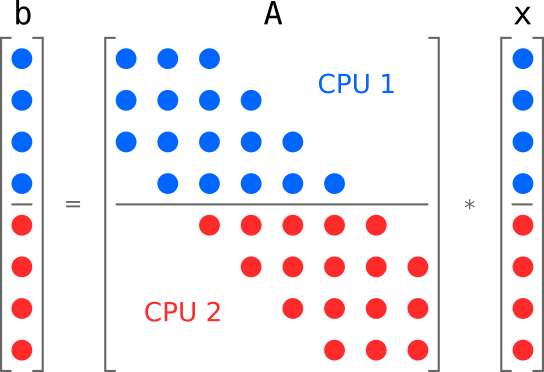
</div>


<div class="alert alert-block alert-success">
<b>Question:</b>  Which parts of $A$ and $x$ are needed to compute the local values of $b$ in a worker? 
</div>


- Answer: Only the entries of x associated with the non-zero columns of A stored in the worker.

### Ghost (halo) columns

<div>
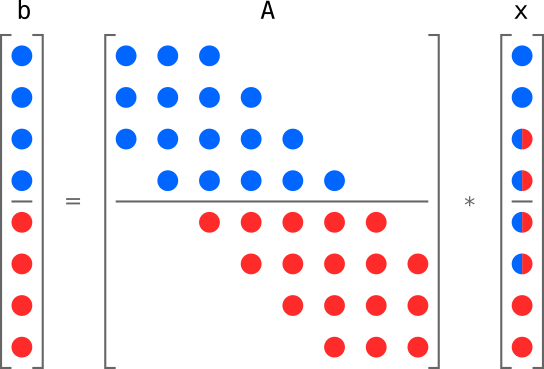
</div>

### Latency hiding

A = A_own + A_ghost



<div>
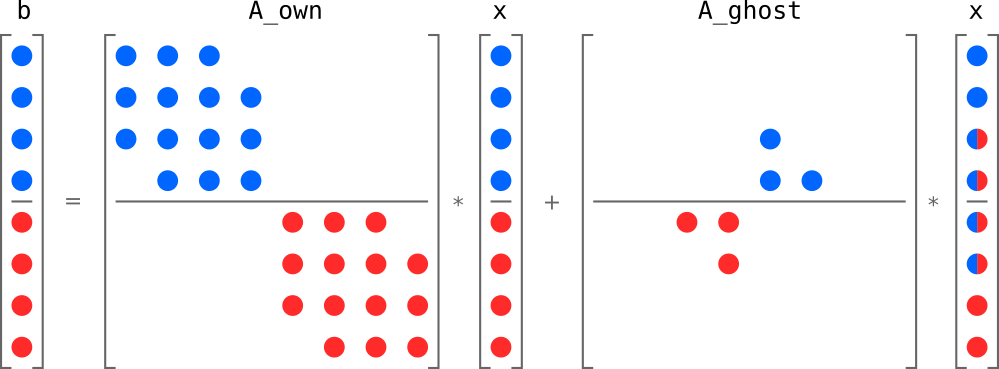
</div>

### Mesh partition

<div class="alert alert-block alert-success">
<b>Question:</b>  Which mesh partition does lead to less communication in the sparse matrix-vector product?
</div>

- Answer: 2d block (as for Jacobi method)


<div>
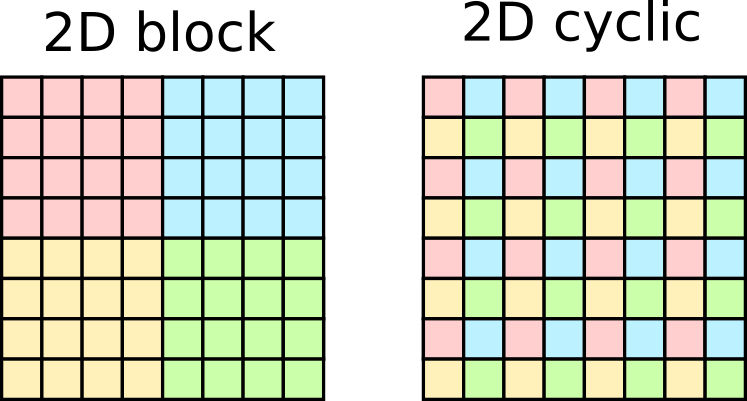
</div>

Remember:  The equation associated with point (i,j) is:

$u_{i-1,j} + u_{i+1,j} + u_{i,j-1} + u_{i,j+1} - 4u_{i,j} = 0$


<div>
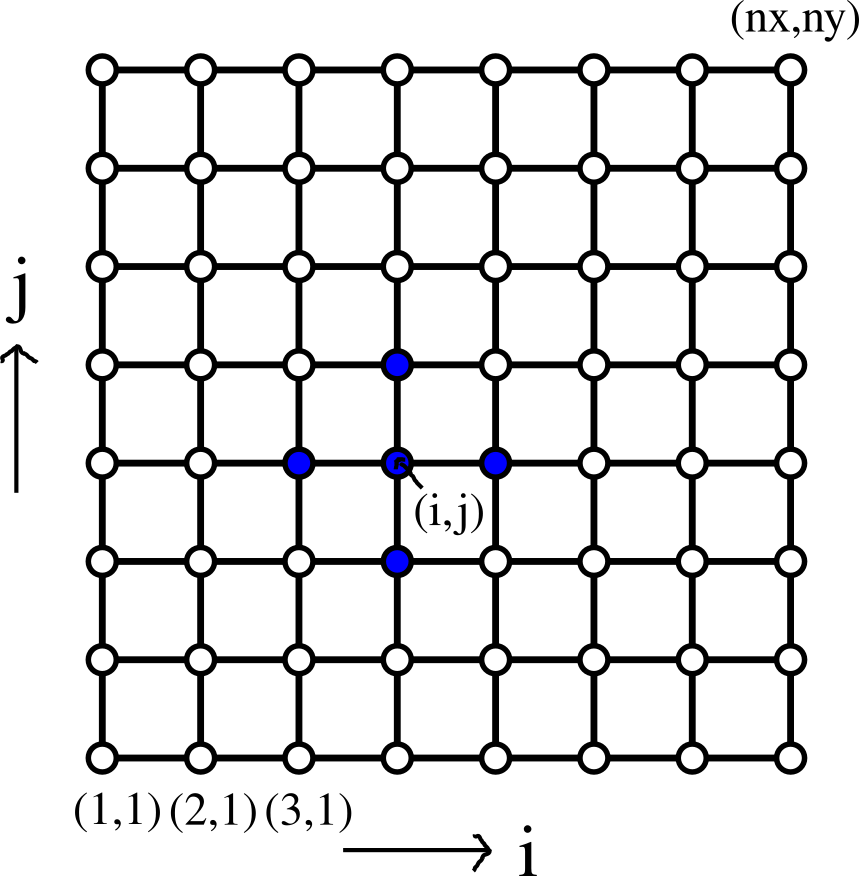
</div>


## How to partition unstructured meshes?

- FEM methods work on unstructured meshes
- One equation per node
- Non-zero columns are associated with nodes connected by mesh edges



<div>
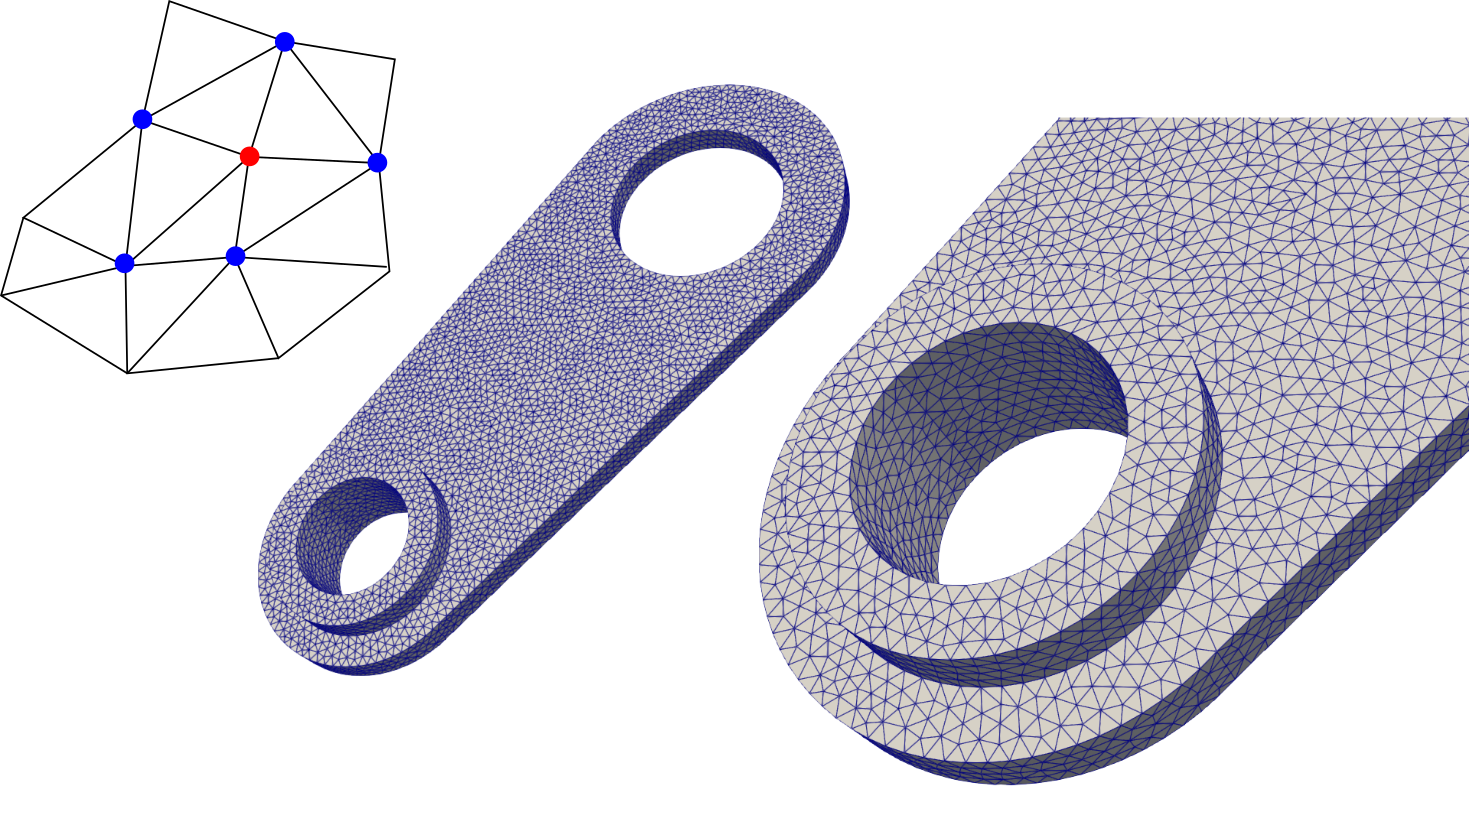
</div>

### k-way graph partitioning problem


Given a graph $G$ (i.e. the mesh)

- Partition the vertices of $G$ into k disjoint parts of equal size (load balance)
- Minimize the number of edges with end vertices belonging to different parts (reduce communication)





### Example

- Partition of a mesh into 8 parts
- Computed with [METIS](https://github.com/KarypisLab/METIS)

<div>
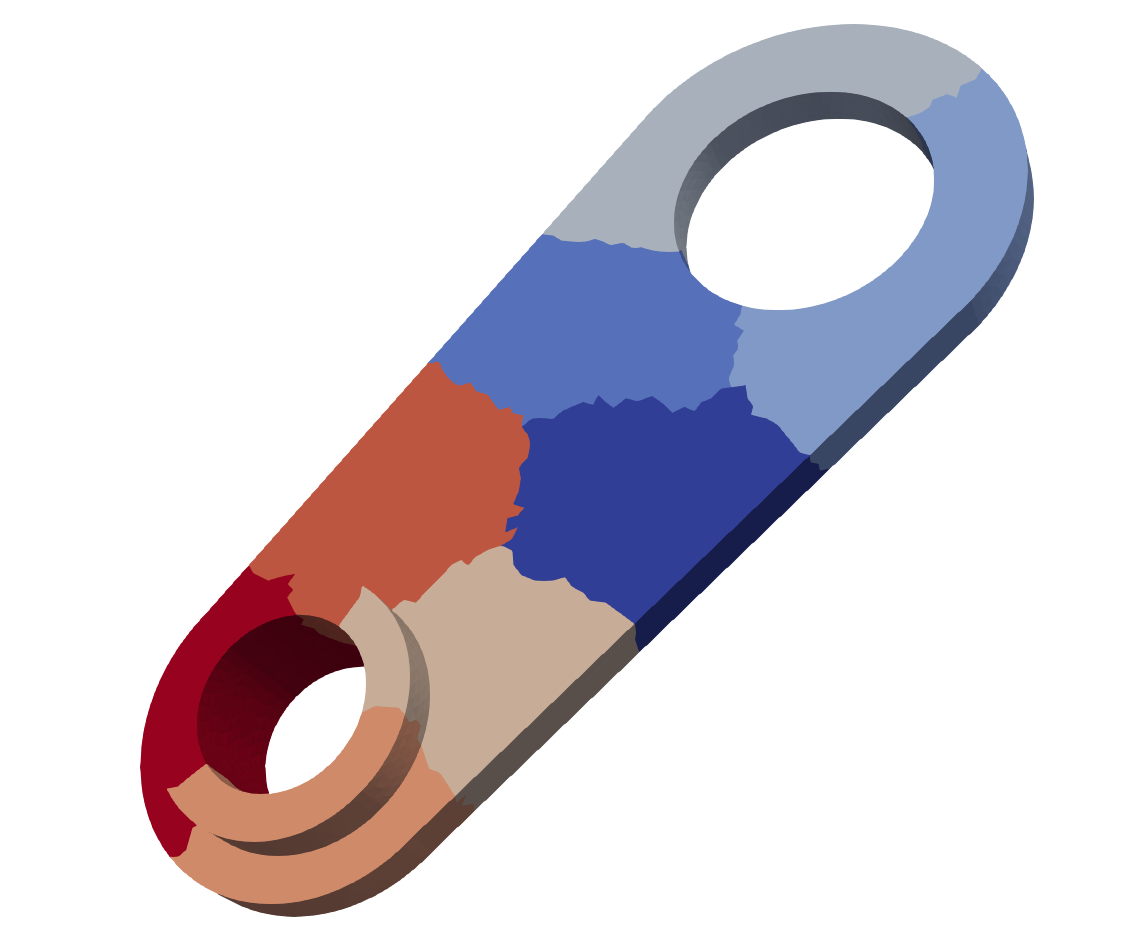
</div>
